# Latent Dirichlet Allocation - IL


* El LDA, es un ***modelo probabilístico*** que se enmarca dentro de los ***modelos generativos*** ya que trata de describir como se crea un documento. (http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)


* El LDA propone que ***un documento se crea mediante la selección de los temas y las palabras de acuerdo a las representaciones probabilísticas del texto natural del documento***.


* El LDA calcula **dos matrices de probabilidad P(w|z) y P(z|θ)**, donde:

    - **P(w|z)**: es la probabilidad de que dado un tema salga una palabra
    - **P(z|θ)**: es la probabilidad de que un documento pertenezca a un tema.
    
    
$$ P(w|\theta) = \sum_{z \in  Z} P(w | z) \cdot P(z|\theta) $$


* ***NOTA***: *existe otro modelo llamado PLSI (Probabilistic Latent Semantic Index) que se enmarca dentro de los modelos probabilísticos (al igual que el LDA) y es el enfoque probabilístico del LSI (siguiendo una distribución uniforme).*



* Siendo

    + ***K***: Número de temas. 
    + ***N***: Número de palabras
    + ***M***: Número de documentos: 
    + ***α***: Parámetro de Dirichlet. Este parámetro es un vector de K componentes que describe el conocimiento a priori que se tiene sobre como los temas se distribuyen en los documentos. 
        * Pocos temas -> Valor de α pequeño
        * Muchos temas  -> Valor de α grande
    + ***Β***: Parámetro de Dirichlet. Este parámetro es un vector de N componentes que describe el conocimiento a priori que se tiene sobre como las palabras se distribuyen en cada tema. 
        * Tema con pocas palabras -> Valor de Β cercano a cero
        * Tema con muchas palabras -> Valor de Β cercano a uno
    + ***θ***: Distribución de probabilidad de que un documento pertenezca a un tema. 
    + ***Z***: Distribución de probabilidad de que una palabra pertenezca a un tema. 
    + ***W***: Identifica todas las palabras en todos los documentos.
    + ***φ***: Distribución de probabilidad de que dado un tema salga una palabra.
    

* ***NOTA***: Si los parámetros ***α y Β*** de la distribución de dirichlet son ***igual a '1'***, el ***LDA se comportaría de la misma manera que el PLSI ya que la distribución de Dirichlet con esos parámetros se comportaría como una distribución uniforme***.


* Haciendo una analogía con el LSI, el ***LDA nos tienen que proporcionar***:
    - Matriz de probabilidades "***Temas-Palabras***": Nos indica la probabilidad de que dado un tema, salga una palabra. 
    - Matriz de probabilidades "***Documentos-Temas***": Nos indica la probabilidad de que un documento pertenezca a un tema.
    
    
* De esta manera podemos ver las relaciones entre palabras y entre documentos.


* ***CUIDADO***: *El LDA trabaja con distribuciones de probabilidad que representan la probabilidad de pertenencia de cada palabra o documento a cada tema. Estas distribuciones de probabilidad no tienen que ser tratadas como vectores de factores latentes (como en el LSI) para calcular similaridades entre documentos, ya que al tratarse de distribuciones de probabilidad no hay que aplicar medidas de distancias para calcular similaridades; si no la ***Divergencia de Kullback-Liebler (KL)*** para estudiar las similaridades entre distribuciones de probabilidad.*


$$ KL(p ||q) = \sum_{i}p(i)ln \frac{p(i)}{q(i)} $$


<hr>


# LDA con Gensim



In [1]:
# https://weiliu2k.github.io/CITS4012/gensim/tf-idf.html
# https://github.com/simplykeerthana/WordCloud-Generator/blob/main/word_cloud_gen.ipynb

import pickle
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

               
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


# Configurar path
os.chdir('C:/iamas_datos2024/proyectos_parlamentarios/')
pd.set_option('display.max_colwidth', None)


# Texto de titulos de proyectos de ley entre 2010 a 2023
texto_df = pickle.load(open('./texto_df_ley_1023.pkl', 'rb'))
texto_df.head(5)



,proyecto_id,titulo,titulo normalizado,cant_token,cant_token_normalizado
2724,HCDN272363,DECLARESE EL 2024 COMO AÑO DEL 140 ANIVERSARIO DE LA PROMULGACION DE LA LEY 1420 DE EDUCACION COMUN.,declaresar aniversario comun,18,3
2730,HCDN272359,"FINANCIAMIENTO DE LOS PARTIDOS POLITICOS - LEY 26215 - Y CODIGO ELECTORAL NACIONAL - LEY 19945 -. MODIFICACIONES SOBRE CONTRATACION DE PUBLICIDAD Y BOLETA UNICA, RESPECTIVAMENTE.",financiamiento partido politico electoral nacional modificación publicidad boleta unico respectivamente,26,10
2732,HCDN272360,EMERGENCIA LABORAL PARA EL PERSONAL DE LA ADMINISTRACION PUBLICA NACIONAL.,emergencia laboral personal publicar nacional,10,5
2733,HCDN272352,CODIGO PENAL DE LA NACION. MODIFICACION DE LOS ARTICULOS 155 Y 169 SOBRE DIFUSION DE CONTENIDO SEXUAL O EROTICO DE TERCEROS Y SIN AUTORIZACION.,penal contenido sexual erotico,24,4
2739,HCDN272353,REFORMA DEL ESTADO. DEROGACION Y MODIFICACION DE DIVERSAS LEYES Y DECRETOS.,reforma decreto,11,2


In [2]:
texto_df.shape

(31334, 5)

In [3]:
# Documentos
corpus = list(texto_df['titulo normalizado'].values)
corpus[0:10]

['declaresar aniversario comun',
 'financiamiento partido politico electoral nacional modificación publicidad boleta unico respectivamente',
 'emergencia laboral personal publicar nacional',
 'penal contenido sexual erotico',
 'reforma decreto',
 'fondo federal desarrollo',
 'democratizacion politico transparencia equidad electoral titulo elección primario abierto simultanea obligatorio',
 'organico partido politico modificación personeria juridico politico',
 'zona franco comercio minorista provincia salta creacion',
 'regimar legal decreto necesidad urgencia modificación integrante funcionamiento comision bicameral permanente tramite legislativo']

## Diccionario y TF IDF

In [5]:
# Para seleccionar solo los de salud
with open('proyecto_df.pkl', 'rb') as file:
    proyecto_df = pickle.load(file)


In [6]:
# Integramos los IL de ley entre 2010 a 2023
proyecto_df['año'] = proyecto_df['publicacion_fecha'].dt.year
filtro_texto_df = pd.merge(texto_df,proyecto_df[['proyecto_id','proyecto_girado_a_comisiones_SALUD','resultado','año']], how = 'inner',left_on = 'proyecto_id', right_on='proyecto_id' )

In [4]:
from pprint import pprint
from gensim import corpora
from gensim.models import TfidfModel
from collections import defaultdict

# retomamos objeto

# ver notebook : 01_NLP-iniciativasleg_salud
# DICCIONARIO
dictionary = pickle.load( open("./dictionary_ley_1023.pkl", "rb"))

# BOLSA DE PALABRAS
BoW_corpus = pickle.load(open('./BoW_corpus_ley_1023.pkl', 'rb'))
#tfidf_corpus = pickle.load(open('./tfidf_corpus_ley_1023.pkl', 'rb'))

# Creamos tf idf DE PALABRAS
tfidf = TfidfModel(BoW_corpus, smartirs='ntc')


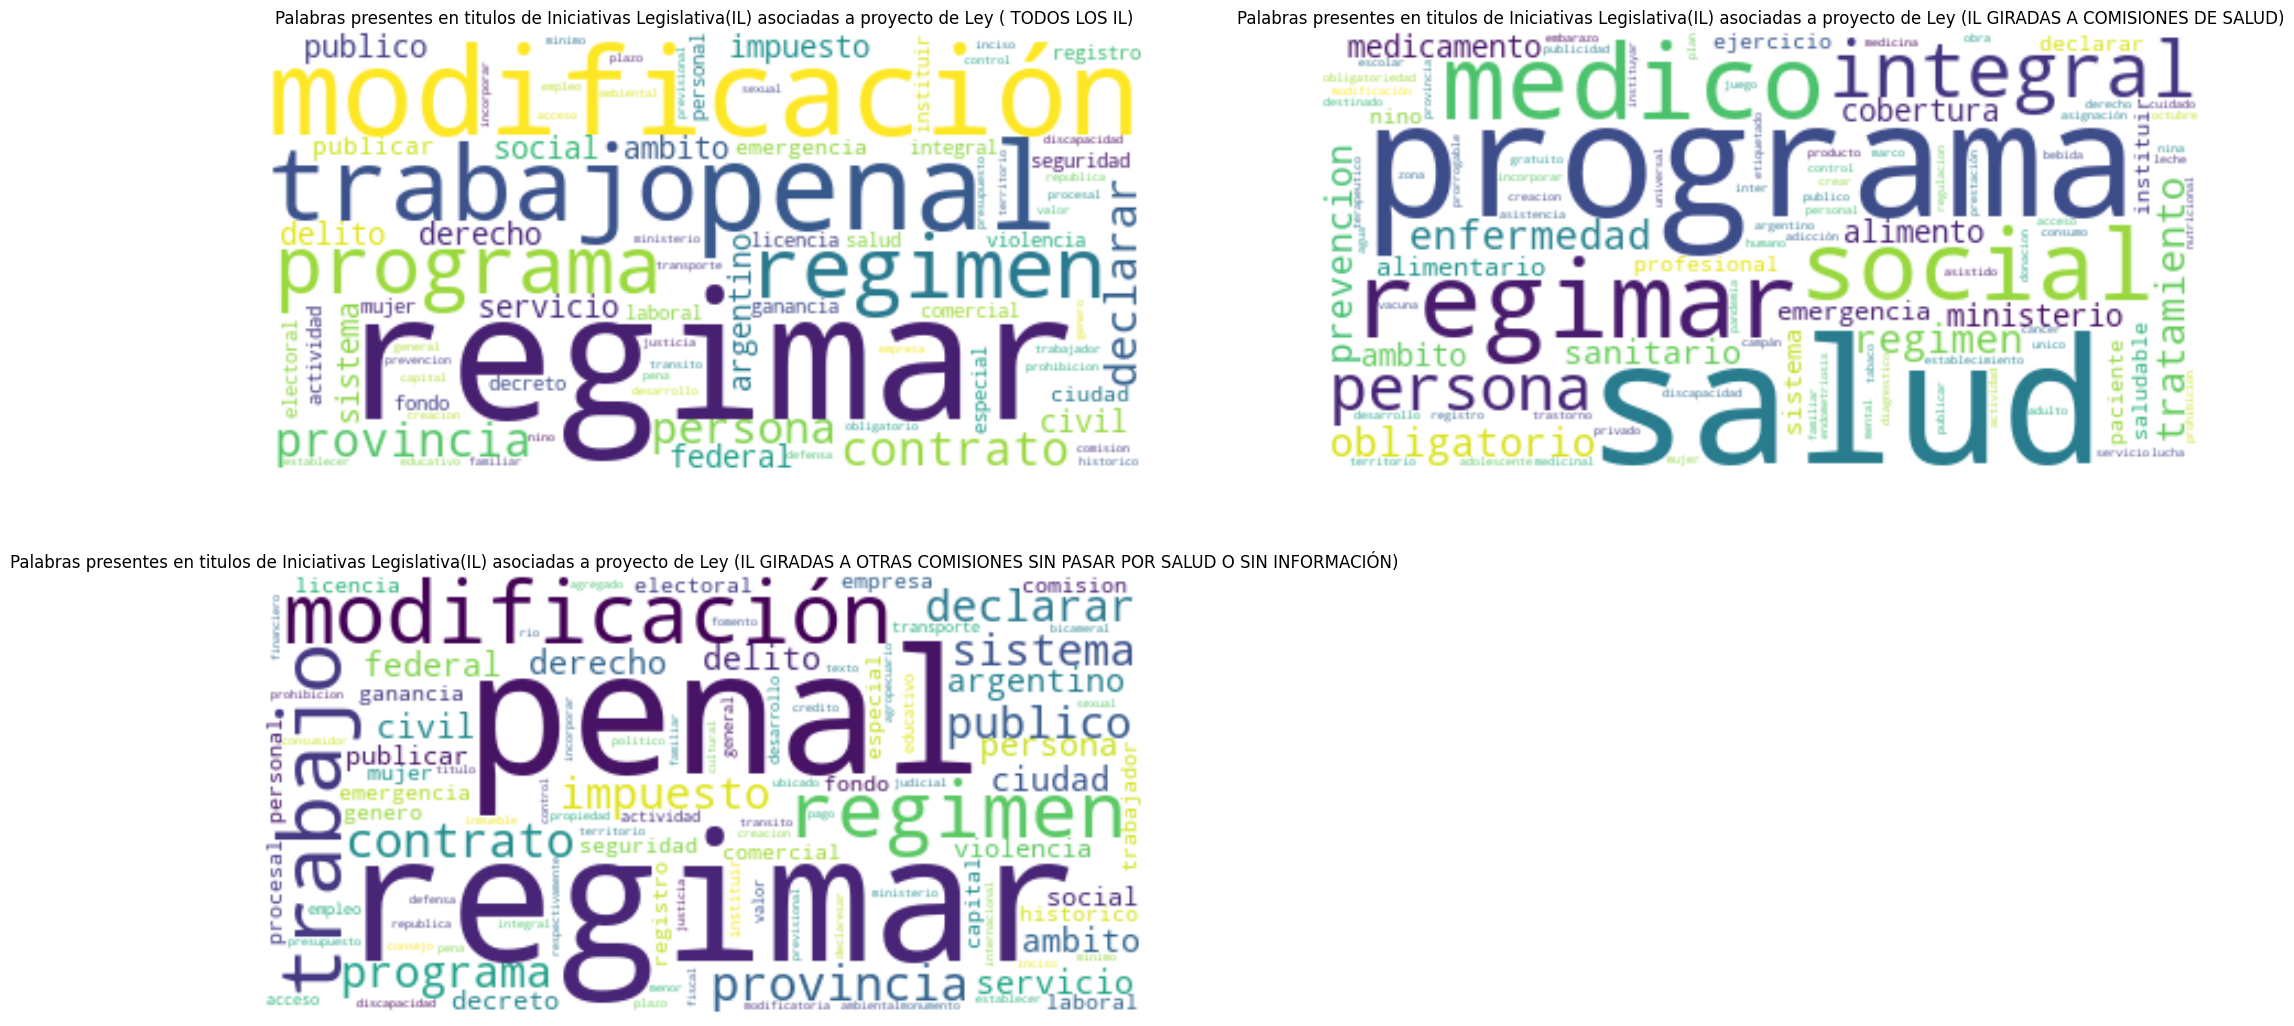

In [8]:
# Para entender mejor numbe de palabras teniendo en peso  tf idf corpus de proyectos de ley entre 2010 a 2023

corpus_norm1 = list(filtro_texto_df['titulo normalizado'].values)
documents_tok1 = [word.split() for word in corpus_norm1]
documents1 = [[token for token in doc] for doc in documents_tok1]

dic_all={}
dic_salud = {}
dic_otras = {}

for i, doc in enumerate(documents1):
    if (filtro_texto_df['proyecto_girado_a_comisiones_SALUD'].values[i] == 'COMISIONES DE SALUD' ):
        for idx, freq in tfidf[dictionary.doc2bow(doc)]:
            key = dictionary[idx]
            if key in dic_all:
                dic_all[key] += np.around(freq,decimals=2)
            else:
                dic_all[key] = np.around(freq,decimals=2)
            if key in dic_salud:
                dic_salud[key] += np.around(freq,decimals=2)
            else:
                dic_salud[key] = np.around(freq,decimals=2)
    else:
        for idx, freq in tfidf[dictionary.doc2bow(doc)]:
            key = dictionary[idx]
            if key in dic_all:
                dic_all[key] += np.around(freq,decimals=2)
            else:
                dic_all[key] = np.around(freq,decimals=2)
            if key in dic_otras:
                dic_otras[key] += np.around(freq,decimals=2)
            else:
                dic_otras[key] = np.around(freq,decimals=2)


words_comisiones = {
    ' Todos los IL': dic_all,
    'IL giradas a comisiones de Salud': dic_salud,
    'IL giradas a otras comisiones sin pasar por salud o sin información':dic_otras
}

plt.figure(figsize=(25, 20))
pos = 1
for key, words in words_comisiones.items():
    plt.subplot(3, 2, pos)
    wordcloud = WordCloud(max_font_size=80, max_words=100, background_color="white").fit_words(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras presentes en titulos de Iniciativas Legislativa(IL) asociadas a proyecto de Ley ({})".format(key.upper()))
    pos += 1
plt.show()

### Iniciativas de proyectos girados a comisiones de SALUD

In [9]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, CoherenceModel

import numpy as np
#from tqdm.notebook import tqdm
from tqdm import tqdm
import sys
from gensim.utils import ClippedCorpus
from ipywidgets import FloatProgress



filtro_texto_SALUD_df = filtro_texto_df[filtro_texto_df['proyecto_girado_a_comisiones_SALUD'] == 'COMISIONES DE SALUD']
print(filtro_texto_SALUD_df.shape)
display(filtro_texto_SALUD_df)

(4011, 8)


,proyecto_id,titulo,titulo normalizado,cant_token,cant_token_normalizado,proyecto_girado_a_comisiones_SALUD,resultado,año
10,HCDN272330,DEFENSA DEL CONSUMIDOR LEY 24240. MODIFICACION DEL ARTICULO 2 SOBRE PROVEEDORES.,defensa consumidor proveedor,11,3,COMISIONES DE SALUD,NaN,2023
11,HCDN272329,"CAMPAÑA NACIONAL PARA LA DIFUSION, CONCIENTIZACION Y PROMOCION DE DONACION VOLUNTARIA DE SANGRE, HEMOCOMPONENTES Y MEDULA OSEA. CREACION.",campán nacional donacion voluntario sangre hemocomponent medula osea,18,8,COMISIONES DE SALUD,NaN,2023
16,HCDN272311,"MARCO REGULATORIO PARA EL CULTIVO, PRODUCCION, DISTRIBUCION, COMERCIALIZACION Y ADQUISICION A CUALQUIER TITULO DEL CANNABIS Y SUS DERIVADOS EN TODO EL TERRITORIO NACIONAL. REGIMEN. MODIFICACION DEL CODIGO PENAL.",marco regulatorio cultivo adquisicion titulo cannabis derivado territorio nacional regimar penal,28,11,COMISIONES DE SALUD,NaN,2023
19,HCDN272307,CAMPAÑA NACIONAL DE PREVENCION DE INCIDENTES CON MONOXIDO DE CARBONO. CREACION.,campán nacional incidente monoxido carbono,11,5,COMISIONES DE SALUD,NaN,2023
29,HCDN272212,REGIMEN DE COMPATIBILIDAD DE BENEFICIOS SOCIALES PARA TRABAJADORES RURALES Y TEMPORARIOS.,regimar compatibilidad beneficio social trabajador rural temporario,11,7,COMISIONES DE SALUD,NaN,2023
...,...,...,...,...,...,...,...,...
31271,HCDN112331,"CODIGO PENAL: MODIFICACION DEL ARTICULO 86, SOBRE DESPENALIZACION DEL ABORTO EN CASO DE VIOLACION O INVIABILIDAD DE VIDA EXTRAUTERINA DEL FETO",penal aborto caso violacion inviabilidad vida extrauterín feto,21,8,COMISIONES DE SALUD,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,2010
31288,HCDN112314,"DECLARAR MONUMENTOS HISTORICOS A LOS EDIFICIOS Y CONSTRUCCIONES EXISTENTES EN LOS PREDIOS HOSPITAL NEUROPSIQUIATRICO MOYANO Y HOSPITAL NEUROPSIQUIATRICO BORDA, DE LA CIUDAD AUTONOMA DE BUENOS AIRES (REPRODUCCION DEL EXPEDIENTE 2342-D-08).",declarar monumento historico edificio construcción existente predio neuropsiquiatrico moyano hospital neuropsiquiatrico bordar ciudad autonomo,30,14,COMISIONES DE SALUD,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,2010
31295,HCDN112347,"MODIFICACION DE LA LEY 25392 DE CREACION DEL ""REGISTRO NACIONAL DE DONANTES DE CELULAS PROGENITORAS HEMATOPOYETICAS"".",registro nacional donante celula progenitora hematopoyetica,16,6,COMISIONES DE SALUD,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,2010
31313,HCDN112727,DEPARTAMENTOS DE LA PROVINCIA DE MENDOZA. SE LAS DECLARA ZONA DE DESASTRE Y EMERGENCIA ECONOMICA Y SOCIAL POR 1 AÑO PRORROGABLE.,departamento provincia declarar zona desastre emergencia economico social prorrogable,21,9,COMISIONES DE SALUD,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,2010


In [10]:
corpus_norm = list(filtro_texto_SALUD_df['titulo normalizado'].values)
# Tokenizamos
documents_tok_SALUD = [word.split() for word in corpus_norm]
documents_SALUD = [[token for token in doc] for doc in documents_tok_SALUD]
dictionary_SALUD = Dictionary(documents_SALUD)

# Diccionario
print('Diccionario Inicial: ', len(dictionary_SALUD))
print(format(dictionary_SALUD))

# Diccionario con más de 5 palabras y con presencia de 50%
# https://radimrehurek.com/gensim/corpora/dictionary.html
# no_below (int, opcional): conserva los tokens que se encuentran en al menos no_below documentos.
# no_above (flotante, opcional): conserva los tokens que están contenidos en no más de no_above documentos (fracción del tamaño total del corpus, no un número absoluto).
dictionary_SALUD.filter_extremes(no_below=5, no_above=0.5)
dictionary_SALUD.compactify()
print('Diccionario Filtrado: ', len(dictionary_SALUD))

# Creamos la Bolsa de Palabras
# Creamos la Bolsa de Palabras
BoW_corpus_SALUD = [dictionary_SALUD.doc2bow(doc) for doc in documents_SALUD]
print('\nPrimer Documento del Corpus:\n{}'.format(BoW_corpus_SALUD[0]))

# tfidf
tfidf_SALUD = TfidfModel(BoW_corpus, smartirs='ntc')
tfidf_SALUD_corpus  = [tfidf[dictionary_SALUD.doc2bow(doc)] for doc in documents_SALUD]



Diccionario Inicial:  3587
Dictionary<3587 unique tokens: ['consumidor', 'defensa', 'proveedor', 'campán', 'donacion']...>
Diccionario Filtrado:  1112

Primer Documento del Corpus:
[(0, 1), (1, 1)]


In [93]:
pickle.dump(dictionary_SALUD, open("./dictionary_SALUD_LEY_1023.pkl", "wb"))
pickle.dump(tfidf_SALUD_corpus, open("./tfidf_SALUD_corpus_LEY_1023.pkl", "wb"))
pickle.dump(BoW_corpus_SALUD, open("./BoW_corpus_SALUD_LEY_1023.pkl", "wb"))


## Creamos el Modelo:

* Gensim tiene implementado el LDA en la clase ***LdaModel***: https://radimrehurek.com/gensim/models/ldamodel.html
* Como parámetros relevantes necesita:
    1. Corpus
    2. Número de Topics
    3. Diccionario o Vocabulario del Corpus

#### Selección del número óptimo de Topics (coherencia)
* https://github.com/RicardoMoya/NLP_with_Python/blob/master/21_Topic_Modeling_noticias.ipynb
* https://www.kaggle.com/code/jrreda/gensim-lda-topic-modeling#Visualize-Results
* https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
* chtgp


**Ajuste de hiperparámetros**

Primero, diferenciemos entre hiperparámetros de modelo y parámetros de modelo:

* Número de temas (K)
* Hiperparámetro de Dirichlet alfa: densidad de temas de documentos
* Hiperparámetro de Dirichlet beta: densidad de temas de palabras

In [12]:
from sklearn.model_selection import GridSearchCV
from gensim.models.ldamodel import LdaModel
import gensim
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import make_scorer
from itertools import product

In [14]:
# Rango de hiperparámetros a probar
# Hiperparámetros
# Si se realiza un ajuste manual, aquí hay valores iniciales típicos para explorar:
# α=0.01 para documentos cortos o especializados.
# β=0.01 a  0.3  para temas compactos y especializados.
# β=0.5 a  1 para temas más diversos.
#param_grid = {
#    'num_topics': [5,10],  #[5, 10, 15],
#    'alpha': ['auto'], #[0.01, 0.1, 'auto'],
#    'beta': ['auto'], #[0.01, 0.1, 'auto'],
#    'iterations': [10,50] #[50, 100, 200]


num_topics_r= [5,10,15,20,25,30,35,40,45,50]  # Número de temas
alpha_r = [0.01, 0.1, 0.3, 'auto']
beta_r = [0.01, 0.1, 0.3, 0.5, 'auto'] # En Gensim, 'eta' equivale a 'beta'

# Crear combinaciones de parámetros
param_combinations = list(product(num_topics_r, alpha_r, beta_r))


# Almacenar resultados
results = []

for e in param_combinations:
    num_topics= e[0]
    alpha = e[1]
    beta = e[2]
    print(f"Entrenando LDA con num_topics={num_topics}, alpha={alpha}, beta={beta}")
    lda_model = LdaModel(
        corpus=tfidf_SALUD_corpus,
        id2word=dictionary_SALUD,
        num_topics=num_topics,
        alpha=alpha,
        eta=beta,
        random_state=42,
        passes=10,
        iterations=100
    )
 
    # Calcular la coherencia 'c_v' 
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=documents_tok_SALUD,
        dictionary=dictionary_SALUD,
        coherence='c_v'  # Métrica c_v es buena para interpretar temas
    )
    coherence_score_c_v = coherence_model_lda.get_coherence()
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=documents_tok_SALUD,
        dictionary=dictionary_SALUD,
        coherence='u_mass'  # Métrica c_v es buena para interpretar temas
    )
    coherence_score_u_mass = coherence_model_lda.get_coherence()

    
    
    # Almacenar los resultados
    results.append({
        'num_topics': num_topics,
        'alpha': alpha,
        'beta': beta,
        'coherence_score_c_v': coherence_score_c_v,
        'coherence_score_u_mass': coherence_score_u_mass
    })

# Ordenar los resultados por coherencia
sorted_results = sorted(results, key=lambda x: x['coherence_score_c_v'], reverse=True)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados por coherence_score_c_v:")
print(sorted_results[0])

Entrenando LDA con num_topics=5, alpha=0.01, beta=0.01
Entrenando LDA con num_topics=5, alpha=0.01, beta=0.1
Entrenando LDA con num_topics=5, alpha=0.01, beta=0.3
Entrenando LDA con num_topics=5, alpha=0.01, beta=0.5
Entrenando LDA con num_topics=5, alpha=0.01, beta=auto
Entrenando LDA con num_topics=5, alpha=0.1, beta=0.01
Entrenando LDA con num_topics=5, alpha=0.1, beta=0.1
Entrenando LDA con num_topics=5, alpha=0.1, beta=0.3
Entrenando LDA con num_topics=5, alpha=0.1, beta=0.5
Entrenando LDA con num_topics=5, alpha=0.1, beta=auto
Entrenando LDA con num_topics=5, alpha=0.3, beta=0.01
Entrenando LDA con num_topics=5, alpha=0.3, beta=0.1
Entrenando LDA con num_topics=5, alpha=0.3, beta=0.3
Entrenando LDA con num_topics=5, alpha=0.3, beta=0.5
Entrenando LDA con num_topics=5, alpha=0.3, beta=auto
Entrenando LDA con num_topics=5, alpha=auto, beta=0.01
Entrenando LDA con num_topics=5, alpha=auto, beta=0.1
Entrenando LDA con num_topics=5, alpha=auto, beta=0.3
Entrenando LDA con num_topics=5

In [15]:
# Se guarda en un dataframes
df = pd.DataFrame(sorted_results)
df

,num_topics,alpha,beta,coherence_score_c_v,coherence_score_u_mass
0,50,0.3,0.3,0.586422,-16.489059
1,50,0.3,0.5,0.566220,-15.887895
2,45,0.3,0.3,0.552930,-15.926375
3,40,0.3,0.5,0.541853,-16.186532
4,50,0.3,0.1,0.529231,-16.227506
...,...,...,...,...,...
195,5,auto,auto,0.327818,-9.893427
196,5,auto,0.3,0.327070,-10.270994
197,5,auto,0.5,0.327060,-10.091469
198,5,0.01,0.3,0.299800,-10.493525


In [74]:
df.to_csv("./gridsearch_50_SALUD_LEY_1023.csv")

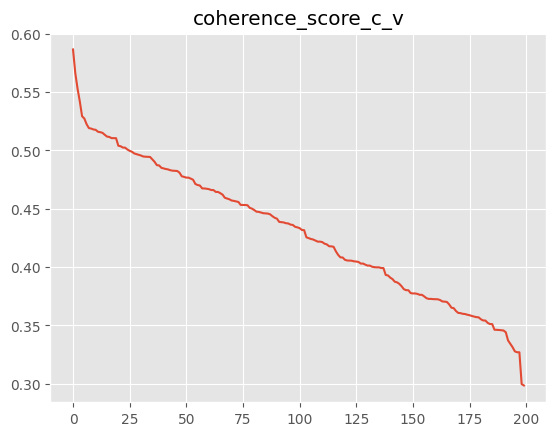

In [16]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df.coherence_score_c_v.plot(kind='line', title='coherence_score_c_v');

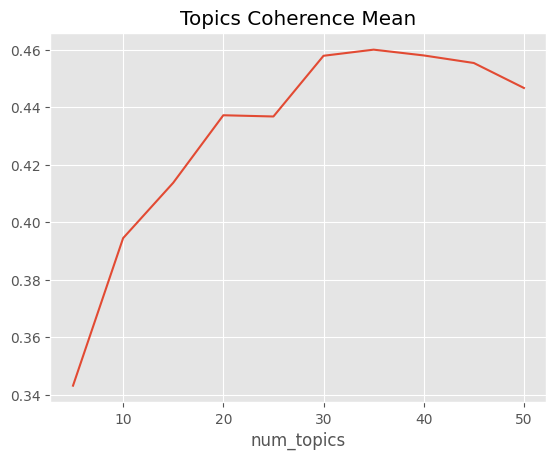

In [17]:
df.groupby('num_topics')['coherence_score_c_v'].mean().plot(title='Topics Coherence Mean');

In [21]:
df[df['num_topics']==35]

,num_topics,alpha,beta,coherence_score_c_v,coherence_score_u_mass
6,35,0.3,0.5,0.522419,-15.829920
7,35,0.3,auto,0.519083,-15.259499
14,35,0.3,0.01,0.513363,-14.797024
24,35,0.3,0.1,0.500726,-15.761703
26,35,0.1,0.1,0.498824,-14.877066
31,35,0.1,auto,0.494759,-15.087624
38,35,0.1,0.01,0.487086,-15.006527
39,35,0.3,0.3,0.485047,-14.768442
49,35,auto,auto,0.477289,-14.469330
53,35,auto,0.01,0.474809,-14.266325


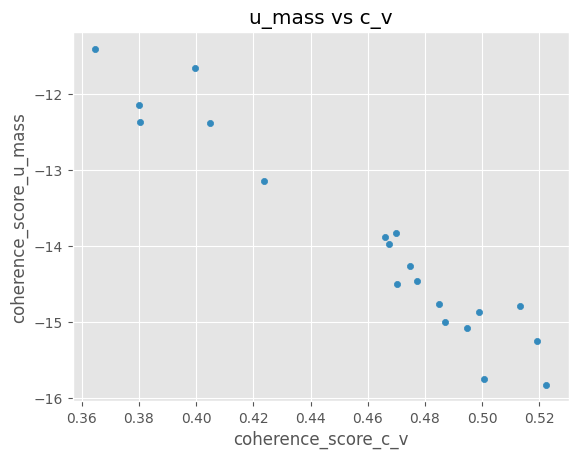

In [26]:
df[df['num_topics']==35].plot.scatter(x='coherence_score_c_v', y='coherence_score_u_mass', title='u_mass vs c_v');

In [27]:
# 35 	auto 	0.3 	
# 35 	0.1 	0.3 	
num_topics = 35
alpha = 'auto'
beta = 0.3
lda_model = LdaModel(
        corpus=tfidf_SALUD_corpus,
        id2word=dictionary_SALUD,
        num_topics=num_topics,
        alpha=alpha,
        eta=beta,
        random_state=42,
        passes=10,
        iterations=100
    )

In [28]:
coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=documents_tok_SALUD,
                                         dictionary=dictionary_SALUD, coherence='c_v')
coherencemodel = CoherenceModel(model=lda_model, texts=documents_tok_SALUD, dictionary=dictionary_SALUD, coherence='u_mass')

print('coherencemodel_c_v:',coherence_model_lda.get_coherence())
print('coherencemodel_u_mas',coherencemodel.get_coherence()) # -15.371240951820052
print('log_perplexity',lda_model.log_perplexity(tfidf_SALUD_corpus)) # -17.76247596312353 #


coherencemodel_c_v: 0.4049599089552954
coherencemodel_u_mas -12.38272750540559
log_perplexity -8.325981304341028


In [29]:
""""
# Mejor modelo
k = 35
a = 0.3 	
b = 0.01
lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_SALUD_corpus, num_topics=k,
                                id2word=dictionary_SALUD, passes=10,
                                alpha=a, eta=b, chunksize=100,
                                per_word_topics=True, random_state=42)
"""

'"\n# Mejor modelo\nk = 35\na = 0.3 \t\nb = 0.01\nlda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_SALUD_corpus, num_topics=k,\n                                id2word=dictionary_SALUD, passes=10,\n                                alpha=a, eta=b, chunksize=100,\n                                per_word_topics=True, random_state=42)\n'

In [30]:
###Save LDA model####
pickle.dump(lda_model, open("./lda_model_SALUD_LEY_1023.pkl", "wb"))


In [31]:
print(lda_model.alpha) # Document-topic prior
print(lda_model.eta)   # Topic-word prior (beta)

[0.02734086 0.01931661 0.02106064 0.02096361 0.01915857 0.03439905
 0.03919288 0.03334195 0.01949835 0.03105137 0.02142707 0.03002268
 0.02707245 0.03057241 0.02928236 0.0216301  0.02963509 0.02707073
 0.02929906 0.02900418 0.01978283 0.04343349 0.01885315 0.03224384
 0.01984593 0.04392819 0.02224917 0.02130252 0.02003466 0.02656548
 0.02221383 0.03255187 0.03289453 0.02136499 0.01885279]
[0.3 0.3 0.3 ... 0.3 0.3 0.3]


In [32]:
#for lst in lda_model[tfidf_SALUD_corpus]:
#    print(lst[0])

## Matriz de probabilidades "***Temas-Palabras***"


* Obtenemos la probabilidad de que dado uno de los 21 temas aparezca una de las 15 palabras. Al igual que en la matriz anterior la suma de todas las probabilidades de las palabras en un tema tiene que sumar '1'.


* A continuación obtenermos la probabilidad de que dado un tema aparezca una palabra:

In [33]:
words_topics = lda_model.get_topics()
words_topics

array([[0.00053816, 0.00053816, 0.00163293, ..., 0.00053816, 0.00117527,
        0.00053816],
       [0.00081469, 0.00081469, 0.00081483, ..., 0.00081469, 0.00081469,
        0.00081469],
       [0.00077619, 0.00077617, 0.0032771 , ..., 0.00077617, 0.00077617,
        0.00077617],
       ...,
       [0.00029094, 0.00029094, 0.00029094, ..., 0.00029096, 0.00029094,
        0.0017476 ],
       [0.00066311, 0.00066311, 0.00066311, ..., 0.00066311, 0.00066311,
        0.00066311],
       [0.00087979, 0.00087979, 0.00087979, ..., 0.00087979, 0.00087979,
        0.0008798 ]], dtype=float32)

In [35]:
lista_topico = []
for i in range(0,35):
    lista_topico.append('Tópico '+str(i))

* De manera más clara los mostramos en una tabla:

In [36]:
pd.DataFrame(words_topics, index=lista_topico, columns=dictionary_SALUD.token2id.keys()).head()

,consumidor,defensa,campán,donacion,hemocomponent,medula,nacional,sangre,voluntario,adquisicion,...,asiento,ordenado,texto,infertilidad,top,parrafo,sufrir,rotavirus,permanencia,puyehue
Tópico 0,0.000538,0.000538,0.001633,0.010813,0.000560,0.002663,0.004289,0.000568,0.001887,0.000538,...,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.001175,0.000538
Tópico 1,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000821,0.000815,0.000815,0.000815,...,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815
Tópico 2,0.000776,0.000776,0.003277,0.000781,0.000776,0.000776,0.000791,0.000776,0.013896,0.000776,...,0.000776,0.000776,0.000776,0.000776,0.000776,0.000776,0.000776,0.000776,0.000776,0.000776
Tópico 3,0.001026,0.000971,0.000713,0.000711,0.000711,0.000711,0.000993,0.001585,0.000711,0.000711,...,0.000711,0.000711,0.000711,0.000711,0.000711,0.000711,0.000711,0.000711,0.000711,0.000711
Tópico 4,0.000844,0.000844,0.000846,0.000844,0.000844,0.000844,0.003644,0.000844,0.000844,0.000844,...,0.000844,0.000844,0.000844,0.000844,0.000844,0.000844,0.000844,0.000844,0.000844,0.000844


In [37]:
# Print topic proportion in corpus
topics = list(lda_model.get_document_topics(tfidf_SALUD_corpus, minimum_probability=0))
for t in range(4):
    print(f"Topico {t} proporción de IL : {100*sum([pair[t][1] for pair in topics])/len(topics):.1f}%")



Topico 0 proporción de IL : 4.3%
Topico 1 proporción de IL : 1.0%
Topico 2 proporción de IL : 1.5%
Topico 3 proporción de IL : 1.8%


## Palabras (terminos) más representativas de un tema (topic)


* Dado que podemos obtener la probabilidad de que dada una palabra (termino) esta pertenezca a un tema (topic), podemos obtener las palabras más representativas por topic de la siguiente manera: 

In [38]:
for i , topic in enumerate(lista_topico):
    print(topic)
    pprint([dictionary_SALUD.id2token[term[0]] for term in lda_model.get_topic_terms(i)[0:7]])

Tópico 0
['instituir',
 'instituyar',
 'octubre',
 'sindrome',
 'mayo',
 'noviembre',
 'donacion']
Tópico 1
['farmacia',
 'jardín',
 'minima',
 'maternal',
 'habilitado',
 'exclusivo',
 'camara']
Tópico 2
['voluntario',
 'publicitario',
 'embarazo',
 'regimar',
 'tecnologia',
 'desempleo',
 'modificación']
Tópico 3
['medicina', 'prepagar', 'entidad', 'obra', 'receta', 'regulatorio', 'marco']
Tópico 4
['alzheimer', 'premio', 'favaloro', 'renir', 'impuesto', 'doctor', 'enfermerio']
Tópico 5
['financiamiento',
 'programa',
 'nacional',
 'cancer',
 'crear',
 'agencia',
 'prenupcial']
Tópico 6
['emergencia',
 'sanitario',
 'nacional',
 'inter',
 'ludopatia',
 'hijo',
 'declarar']
Tópico 7
['leyenda',
 'elaborado',
 'producto',
 'alimenticio',
 'obligatoriedad',
 'tabaco',
 'publicidad']
Tópico 8
['habito',
 'catastrofica',
 'saludable',
 'politica',
 'estupefaciente',
 'alto',
 'morbimortalidad']
Tópico 9
['publico', 'establecimiento', 'servicio', 'privado', 'agua', 'salud', 'acceso']
Tópic

<hr>


## Topics & Terms


* Gensim nos devuelve un "formula" por tema (Topic) que aplicada a las apariciones de las palabras en los documentos nos indica la pertenencia del nuevo documento a ese tema. El que mayor valor tenga tras aplicar la fórmula del tema al documento significará que tiene mayor propensión a pertenecer a ese tema.


* Si os fijáis esa fórmula la construye como el sumatorio de la aparición de la palabra en el documento, multiplicado por la probabilidad de que en ese temá aparezca esa palabra:

In [39]:
lda_model.print_topics(num_words=15)

[(22,
  '0.009*"equinoterapiar" + 0.008*"propiedad" + 0.005*"inmueble" + 0.004*"terciario" + 0.004*"gratuito" + 0.004*"universitario" + 0.004*"provincia" + 0.003*"estudiante" + 0.003*"transferenciar" + 0.003*"rio" + 0.003*"favor" + 0.002*"sociedad" + 0.002*"ubicado" + 0.002*"nacional" + 0.002*"funcionamiento"'),
 (34,
  '0.006*"utilizacion" + 0.004*"nombre" + 0.003*"medicamento" + 0.003*"generico" + 0.002*"paciente" + 0.002*"identificacion" + 0.002*"ex" + 0.002*"regimen" + 0.002*"pensión" + 0.002*"pediatrico" + 0.002*"reconocimiento" + 0.001*"receta" + 0.001*"grave" + 0.001*"equinoterapia" + 0.001*"requeír"'),
 (4,
  '0.008*"alzheimer" + 0.007*"premio" + 0.006*"favaloro" + 0.005*"renir" + 0.005*"impuesto" + 0.005*"doctor" + 0.004*"enfermerio" + 0.004*"nacional" + 0.003*"responsabilidad" + 0.003*"social" + 0.003*"bancario" + 0.003*"pueblo" + 0.003*"fisico" + 0.003*"institucion" + 0.003*"debito"'),
 (1,
  '0.010*"farmacia" + 0.006*"jardín" + 0.005*"minima" + 0.005*"maternal" + 0.005*"hab

<hr>


# Visualización


* Existe una librería llamada "***pyLDAvis***" que nos permite visualizar las relaciones entre los temas (topic) y dentro de cada tema la importancia de sus palabras (terms).


* La parte de visualización de esta librería nos permite ver:
    - Parte Izquierda: Visualización de los temas en función de dos componentes (2 Dimensiones)
    - Parte Derecha: Seleccionado un Topic, podemos ver las palabras (terms) más relevantes de ese tema y la frecuencia con la que aparecen tanto en el corpus como en el tema.
    
    
* En esta visualización podemos apreciar como se distinguen los tres temas claramente ya que las dos componentes que las definen son claramente distintas.

In [40]:
import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, tfidf_SALUD_corpus, dictionary_SALUD, mds='mmds')
pyLDAvis.display(vis)

#### PALABRAS DE LOS TOPICOS

In [41]:
####lambda## aca puedo obtener la probabilidad de cada palabra para cada topico
topics_terms = lda_model.state.get_lambda() 
#convert estimates to probability (sum equals to 1 per topic)
topics_terms_proba = np.apply_along_axis(lambda x: x/x.sum(),1,topics_terms)

In [42]:
###Hago un archivo con el total del diccionario
top_words_per_topic = []
for t in range(lda_model.num_topics):
    #top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = len(id2word))])
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 20)])


#pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("../resultados/total_words.csv")
top_words=pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])
table = pd.pivot_table(top_words, values='P', index=['Word'],columns=['Topic'], aggfunc=np.sum)
top_words.to_csv("./words_probabilities_SALUD_LEY_1023.csv")


C:\Users\Usuario\AppData\Local\Temp\ipykernel_26448\1237628342.py:10: FutureWarning: The provided callable <function sum at 0x00000245E009BB00> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  table = pd.pivot_table(top_words, values='P', index=['Word'],columns=['Topic'], aggfunc=np.sum)


In [43]:
# Top 50 palabras asociadas a proyecto de salud
top_words.sort_values(by='P', ascending=False).head(50)

,Topic,Word,P
100,5,financiamiento,0.206520
120,6,emergencia,0.175919
280,14,registro,0.172293
281,14,donante,0.155825
101,5,programa,0.153660
121,6,sanitario,0.149871
340,17,autonomo,0.143068
420,21,medico,0.125946
341,17,hospital,0.124561
140,7,leyenda,0.118653


#### INICIATIVAS LEGISLATIVA POR TOPICO

In [44]:
#############ARMA TOPICOS - PROBABILIDADES#####
lda_model.n_topics= 35
topicnames = ["Tópico" + str(i) for i in range(lda_model.n_topics)]
rango=len(tfidf_SALUD_corpus)
docnames = ["Doc" + str(i) for i in range(rango)]


##### Get document - topic values
theta, _ = lda_model.inference(tfidf_SALUD_corpus)
theta /= theta.sum(axis=1)[:, None]

In [45]:
# rango
# filtro_texto_SALUD_df.shape

In [46]:
##Trae el ID##
series = pd.Series(filtro_texto_SALUD_df['proyecto_id'])


df_document_topic = pd.DataFrame(np.round(theta,3), columns=topicnames, index=series)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topico_dominante'] = dominant_topic

df_document_topic=df_document_topic.reset_index()
df_document_topic[['proyecto_id','topico_dominante']]


,proyecto_id,topico_dominante
0,HCDN272330,31
1,HCDN272329,0
2,HCDN272311,11
3,HCDN272307,5
4,HCDN272212,11
...,...,...
4006,HCDN112331,16
4007,HCDN112314,17
4008,HCDN112347,14
4009,HCDN112727,32


In [47]:
df_topic_distribution = df_document_topic['topico_dominante'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,25,544
1,9,334
2,31,330
3,23,296
4,11,249
5,0,220
6,12,218
7,21,210
8,29,181
9,6,141


In [48]:
top_words[top_words['Topic']==25].sort_values(by='P', ascending = False)

,Topic,Word,P
500,25,persona,0.089175
501,25,integral,0.027074
502,25,sistema,0.023574
503,25,salud,0.021780
504,25,modificación,0.021551
505,25,social,0.016218
506,25,discapacidad,0.015867
507,25,derecho,0.012353
508,25,obra,0.011134
509,25,regimar,0.011118


In [49]:
#filtro_texto_SALUD_df[filtro_texto_SALUD_df['proyecto_id']=='HCDN112240'].head(4)

### TÓPICOS EN EL TIEMPO

In [50]:
filtro_texto_SALUD_df = filtro_texto_SALUD_df[['proyecto_id', 'titulo', 'titulo normalizado', 'cant_token',
       'cant_token_normalizado', 'proyecto_girado_a_comisiones_SALUD',
       'resultado', 'año']]

In [51]:
filtro_texto_SALUD_df = pd.merge(filtro_texto_SALUD_df, df_document_topic[['proyecto_id','topico_dominante']], how = 'left',left_on = 'proyecto_id', right_on='proyecto_id')
filtro_texto_SALUD_df.head()

,proyecto_id,titulo,titulo normalizado,cant_token,cant_token_normalizado,proyecto_girado_a_comisiones_SALUD,resultado,año,topico_dominante
0,HCDN272330,DEFENSA DEL CONSUMIDOR LEY 24240. MODIFICACION DEL ARTICULO 2 SOBRE PROVEEDORES.,defensa consumidor proveedor,11,3,COMISIONES DE SALUD,NaN,2023,31
1,HCDN272329,"CAMPAÑA NACIONAL PARA LA DIFUSION, CONCIENTIZACION Y PROMOCION DE DONACION VOLUNTARIA DE SANGRE, HEMOCOMPONENTES Y MEDULA OSEA. CREACION.",campán nacional donacion voluntario sangre hemocomponent medula osea,18,8,COMISIONES DE SALUD,NaN,2023,0
2,HCDN272311,"MARCO REGULATORIO PARA EL CULTIVO, PRODUCCION, DISTRIBUCION, COMERCIALIZACION Y ADQUISICION A CUALQUIER TITULO DEL CANNABIS Y SUS DERIVADOS EN TODO EL TERRITORIO NACIONAL. REGIMEN. MODIFICACION DEL CODIGO PENAL.",marco regulatorio cultivo adquisicion titulo cannabis derivado territorio nacional regimar penal,28,11,COMISIONES DE SALUD,NaN,2023,11
3,HCDN272307,CAMPAÑA NACIONAL DE PREVENCION DE INCIDENTES CON MONOXIDO DE CARBONO. CREACION.,campán nacional incidente monoxido carbono,11,5,COMISIONES DE SALUD,NaN,2023,5
4,HCDN272212,REGIMEN DE COMPATIBILIDAD DE BENEFICIOS SOCIALES PARA TRABAJADORES RURALES Y TEMPORARIOS.,regimar compatibilidad beneficio social trabajador rural temporario,11,7,COMISIONES DE SALUD,NaN,2023,11


In [52]:
# Salud y ley - ver
filtro_texto_SALUD_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
proyecto_id,4011,4011,HCDN272330,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
titulo,4011,3831,EJERCICIO PROFESIONAL DE LA OBSTETRICIA. REGIMEN.,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
titulo normalizado,4011,3130,medicamento publicidad multa respectivamente,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cant_token,4011.0,NaN,NaN,NaN,19.320369,10.021316,2.0,12.0,18.0,25.0,125.0
cant_token_normalizado,4011.0,NaN,NaN,NaN,8.074545,4.16531,1.0,5.0,7.0,10.0,32.0
proyecto_girado_a_comisiones_SALUD,4011,1,COMISIONES DE SALUD,4011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resultado,3996,3,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,3878,NaN,NaN,NaN,NaN,NaN,NaN,NaN
año,4011.0,NaN,NaN,NaN,2016.707056,3.813769,2010.0,2014.0,2017.0,2020.0,2023.0
topico_dominante,4011.0,NaN,NaN,NaN,18.132635,9.976774,0.0,9.0,21.0,26.0,34.0


In [53]:
# Para ver por años, resultado, girado a comision
ano_tipo_df = pd.pivot_table(filtro_texto_SALUD_df, values=['proyecto_id'], index=['año','topico_dominante'],
                       aggfunc={'proyecto_id': "count"}).reset_index()
#ano_tipo_df

In [63]:
ano_tipo_df.sort_values(by='proyecto_id', ascending = False).head(4)

,año,topico_dominante,proyecto_id
341,2020,25,60
276,2018,25,53
400,2022,25,47
372,2021,25,46


<Axes: xlabel='año', ylabel='proyecto_id'>

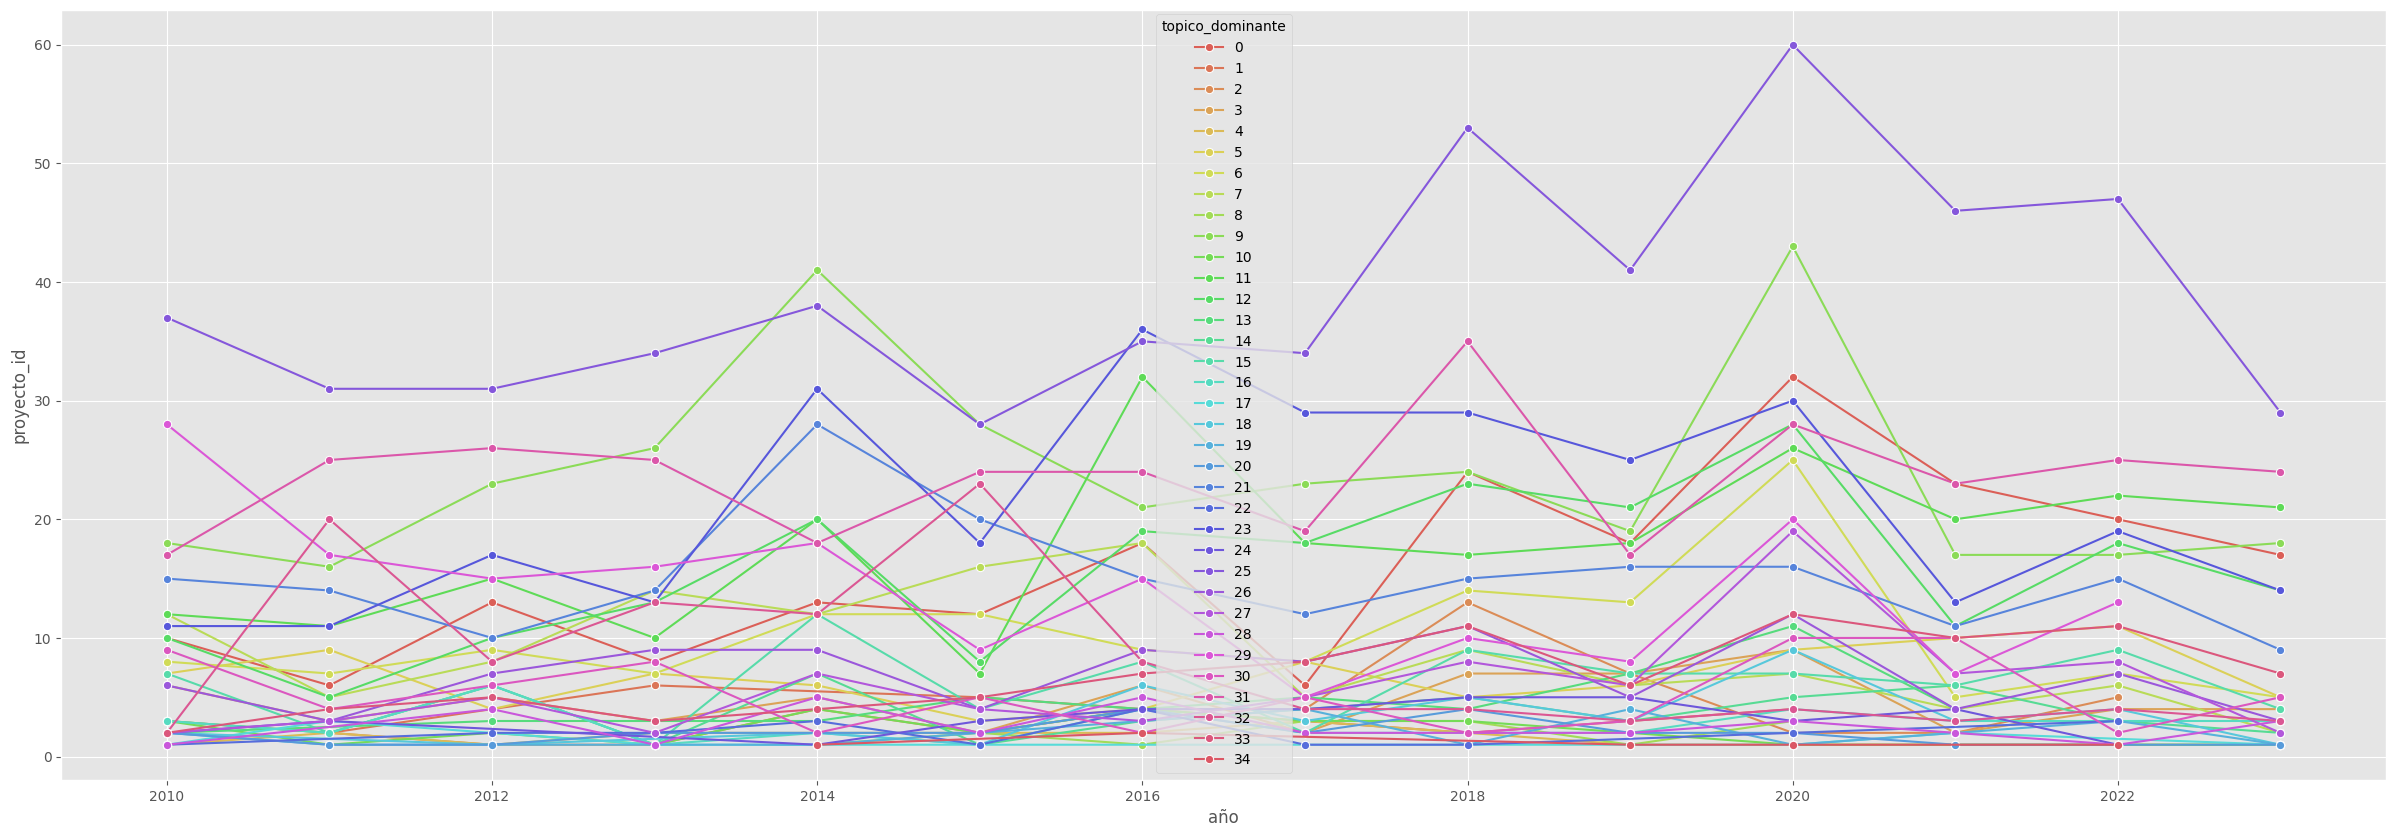

In [56]:
import seaborn as sns 

palette = sns.color_palette("hls", 35)
f, ax = plt.subplots( figsize=(30, 10))
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum',  hue = 'topico_dominante', marker="o" ,palette = palette, data =ano_tipo_df,  errorbar= None , linestyle='-',ax = ax)


In [66]:
ano_tipo_df[ano_tipo_df['año']==2020].sort_values(by='proyecto_id', ascending = False).head()

,año,topico_dominante,proyecto_id
341,2020,25,60
325,2020,9,43
317,2020,0,32
339,2020,23,30
347,2020,31,28


In [58]:
for i , topic in enumerate(lista_topico):
    print(topic)
    pprint([dictionary_SALUD.id2token[term[0]] for term in lda_model.get_topic_terms(i)[0:7]])

Tópico 0
['instituir',
 'instituyar',
 'octubre',
 'sindrome',
 'mayo',
 'noviembre',
 'donacion']
Tópico 1
['farmacia',
 'jardín',
 'minima',
 'maternal',
 'habilitado',
 'exclusivo',
 'camara']
Tópico 2
['voluntario',
 'publicitario',
 'embarazo',
 'regimar',
 'tecnologia',
 'desempleo',
 'modificación']
Tópico 3
['medicina', 'prepagar', 'entidad', 'obra', 'receta', 'regulatorio', 'marco']
Tópico 4
['alzheimer', 'premio', 'favaloro', 'renir', 'impuesto', 'doctor', 'enfermerio']
Tópico 5
['financiamiento',
 'programa',
 'nacional',
 'cancer',
 'crear',
 'agencia',
 'prenupcial']
Tópico 6
['emergencia',
 'sanitario',
 'nacional',
 'inter',
 'ludopatia',
 'hijo',
 'declarar']
Tópico 7
['leyenda',
 'elaborado',
 'producto',
 'alimenticio',
 'obligatoriedad',
 'tabaco',
 'publicidad']
Tópico 8
['habito',
 'catastrofica',
 'saludable',
 'politica',
 'estupefaciente',
 'alto',
 'morbimortalidad']
Tópico 9
['publico', 'establecimiento', 'servicio', 'privado', 'agua', 'salud', 'acceso']
Tópic

In [76]:
pickle.dump(filtro_texto_SALUD_df, open("./filtro_texto_SALUD_df_LEY_1023.pkl", "wb"))

## Exploramos entidades

In [84]:
import spacy
nlp = spacy.load('es_core_news_sm')

In [85]:
# Ejemplo
doc = nlp("cada de mayo de Hospital")
for entity in doc.ents:
    print(entity.text, entity.label_)

Hospital LOC


In [86]:
# obtener entidades
def get_entities(text):
    doc = nlp(text)
    entidades_l = []
    for entity in doc.ents:
        entidades_l.append((entity.text, entity.label_))
    return entidades_l   
    


In [90]:
# entidades
filtro_texto_SALUD_df['entidades'] = filtro_texto_SALUD_df['titulo'].apply(lambda x: get_entities(x) )


In [91]:
filtro_texto_SALUD_df[['titulo','titulo normalizado','entidades']]

,titulo,titulo normalizado,entidades
0,DEFENSA DEL CONSUMIDOR LEY 24240. MODIFICACION DEL ARTICULO 2 SOBRE PROVEEDORES.,defensa consumidor proveedor,"[(CONSUMIDOR, MISC), (MODIFICACION, MISC), (ARTICULO, MISC), (PROVEEDORES, ORG)]"
1,"CAMPAÑA NACIONAL PARA LA DIFUSION, CONCIENTIZACION Y PROMOCION DE DONACION VOLUNTARIA DE SANGRE, HEMOCOMPONENTES Y MEDULA OSEA. CREACION.",campán nacional donacion voluntario sangre hemocomponent medula osea,"[(CAMPAÑA NACIONAL, ORG), (DIFUSION, LOC), (CONCIENTIZACION, LOC), (PROMOCION, ORG), (DONACION, ORG), (VOLUNTARIA DE SANGRE, MISC), (HEMOCOMPONENTES, ORG), (MEDULA OSEA, MISC), (CREACION, MISC)]"
2,"MARCO REGULATORIO PARA EL CULTIVO, PRODUCCION, DISTRIBUCION, COMERCIALIZACION Y ADQUISICION A CUALQUIER TITULO DEL CANNABIS Y SUS DERIVADOS EN TODO EL TERRITORIO NACIONAL. REGIMEN. MODIFICACION DEL CODIGO PENAL.",marco regulatorio cultivo adquisicion titulo cannabis derivado territorio nacional regimar penal,"[(MARCO, MISC), (REGULATORIO, ORG), (CULTIVO, MISC), (PRODUCCION, MISC), (DISTRIBUCION, ORG), (COMERCIALIZACION, ORG), (ADQUISICION, MISC), (CUALQUIER, ORG), (CANNABIS, MISC), (DERIVADOS, MISC), (TODO, MISC), (TERRITORIO, MISC), (REGIMEN, ORG), (MODIFICACION, MISC), (CODIGO, ORG)]"
3,CAMPAÑA NACIONAL DE PREVENCION DE INCIDENTES CON MONOXIDO DE CARBONO. CREACION.,campán nacional incidente monoxido carbono,"[(CAMPAÑA NACIONAL, ORG), (PREVENCION, ORG), (INCIDENTES, ORG), (MONOXIDO, ORG), (CARBONO, ORG), (CREACION, MISC)]"
4,REGIMEN DE COMPATIBILIDAD DE BENEFICIOS SOCIALES PARA TRABAJADORES RURALES Y TEMPORARIOS.,regimar compatibilidad beneficio social trabajador rural temporario,"[(REGIMEN, ORG), (COMPATIBILIDAD, ORG), (BENEFICIOS SOCIALES, ORG), (RURALES, ORG), (TEMPORARIOS, ORG)]"
...,...,...,...
4006,"CODIGO PENAL: MODIFICACION DEL ARTICULO 86, SOBRE DESPENALIZACION DEL ABORTO EN CASO DE VIOLACION O INVIABILIDAD DE VIDA EXTRAUTERINA DEL FETO",penal aborto caso violacion inviabilidad vida extrauterín feto,"[(CODIGO, ORG), (MODIFICACION, MISC), (ARTICULO 86, MISC), (DESPENALIZACION, ORG), (CASO, MISC), (VIOLACION, MISC), (INVIABILIDAD, ORG), (EXTRAUTERINA, ORG), (FETO, ORG)]"
4007,"DECLARAR MONUMENTOS HISTORICOS A LOS EDIFICIOS Y CONSTRUCCIONES EXISTENTES EN LOS PREDIOS HOSPITAL NEUROPSIQUIATRICO MOYANO Y HOSPITAL NEUROPSIQUIATRICO BORDA, DE LA CIUDAD AUTONOMA DE BUENOS AIRES (REPRODUCCION DEL EXPEDIENTE 2342-D-08).",declarar monumento historico edificio construcción existente predio neuropsiquiatrico moyano hospital neuropsiquiatrico bordar ciudad autonomo,"[(MONUMENTOS HISTORICOS A, MISC), (CONSTRUCCIONES EXISTENTES, ORG), (HOSPITAL NEUROPSIQUIATRICO MOYANO, MISC), (HOSPITAL NEUROPSIQUIATRICO BORDA, MISC), (AUTONOMA, LOC), (BUENOS AIRES, LOC), (EXPEDIENTE, MISC)]"
4008,"MODIFICACION DE LA LEY 25392 DE CREACION DEL ""REGISTRO NACIONAL DE DONANTES DE CELULAS PROGENITORAS HEMATOPOYETICAS"".",registro nacional donante celula progenitora hematopoyetica,"[(MODIFICACION, ORG), (CREACION, MISC), (DONANTES, ORG), (CELULAS, ORG), (HEMATOPOYETICAS, MISC)]"
4009,DEPARTAMENTOS DE LA PROVINCIA DE MENDOZA. SE LAS DECLARA ZONA DE DESASTRE Y EMERGENCIA ECONOMICA Y SOCIAL POR 1 AÑO PRORROGABLE.,departamento provincia declarar zona desastre emergencia economico social prorrogable,"[(DECLARA, MISC), (DESASTRE, MISC), (EMERGENCIA ECONOMICA, MISC), (AÑO, MISC)]"


In [92]:
pickle.dump(filtro_texto_SALUD_df, open("./filtro_texto_SALUD_df_LEY_1023.pkl", "wb"))

In [ ]:
#https://stackoverflow.com/questions/63777101/topic-wise-document-distribution-in-gensim-lda